In [34]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

In [35]:
# Load the data
df_customers = pd.read_csv("../data/customers.csv")
df_churn = pd.read_csv("../data/churn.csv")
df_transactions = pd.read_csv("../data/transactions_summary.csv")

# Common key 'customer_id' to merge the DataFrames
df = pd.merge(df_customers, df_churn, on='customer_id')

In [36]:
# Remove any negative age entries
df = df[df['age'] >= 0]
# Remove entries where the person is married or divorced and age is less than 21
df = df[~((df['marital'].isin(['married', 'divorced'])) & (df['age'] < 21))]
# Check for missing values
missing_values = df.isnull().sum()
print("Missing values in each column:")
print(missing_values)

Missing values in each column:
customer_id              0
age                      0
job                      0
marital                  0
education                0
credit_default           0
customer_segment         0
region                   0
income                   0
created_at               0
credit_card              0
personal_loan            0
mortgage                 0
savings_account          0
investment_product       0
auto_loan                0
wealth_management        0
churn_id                 0
churn_status             0
churn_date            9472
dtype: int64


In [37]:
# Add a column to indicate if the account is not active (last transaction more than 6 months old)
df['account_active'] = df_transactions['days_since_last_transaction'].apply(lambda x: 0 if x > 180 else 1)

# Convert 'created_at' to datetime
df['created_at'] = pd.to_datetime(df['created_at'])

# Calculate tenure in years and round up
current_date = datetime.now()
df['tenure'] = (current_date - df['created_at']).apply(lambda x: np.ceil(x.days / 365)).astype(int)

# Convert binary columns from 'yes'/'no' to 1/0
binary_columns = df.columns[9:16]
df[binary_columns] = df[binary_columns].map(lambda x: 1 if x == 'yes' else 0)
df['churn_status'] = df['churn_status'].apply(lambda x: 1 if x == 'Yes' else 0)
df['credit_default'] = df['credit_default'].apply(lambda x: 1 if x == 'Yes' else 0)

# Create a new column 'total_products_purchased' by summing the binary columns
df['total_products_purchased'] = df[binary_columns].sum(axis=1)

# Calculate product utilization rate by income and tenure
df['product_utilization_rate_by_income'] = df['total_products_purchased'] / df['income']
df['product_utilization_rate_by_tenure'] = df['total_products_purchased'] / df['tenure']


In [38]:
# Print the number of customers by relevant
num_churned_customers = df['churn_status'].sum()
print("Number of churned customers:", num_churned_customers)
num_active_customers = df['account_active'].sum()
print("Number of active customers:", num_active_customers)

Number of churned customers: 401
Number of active customers: 9646


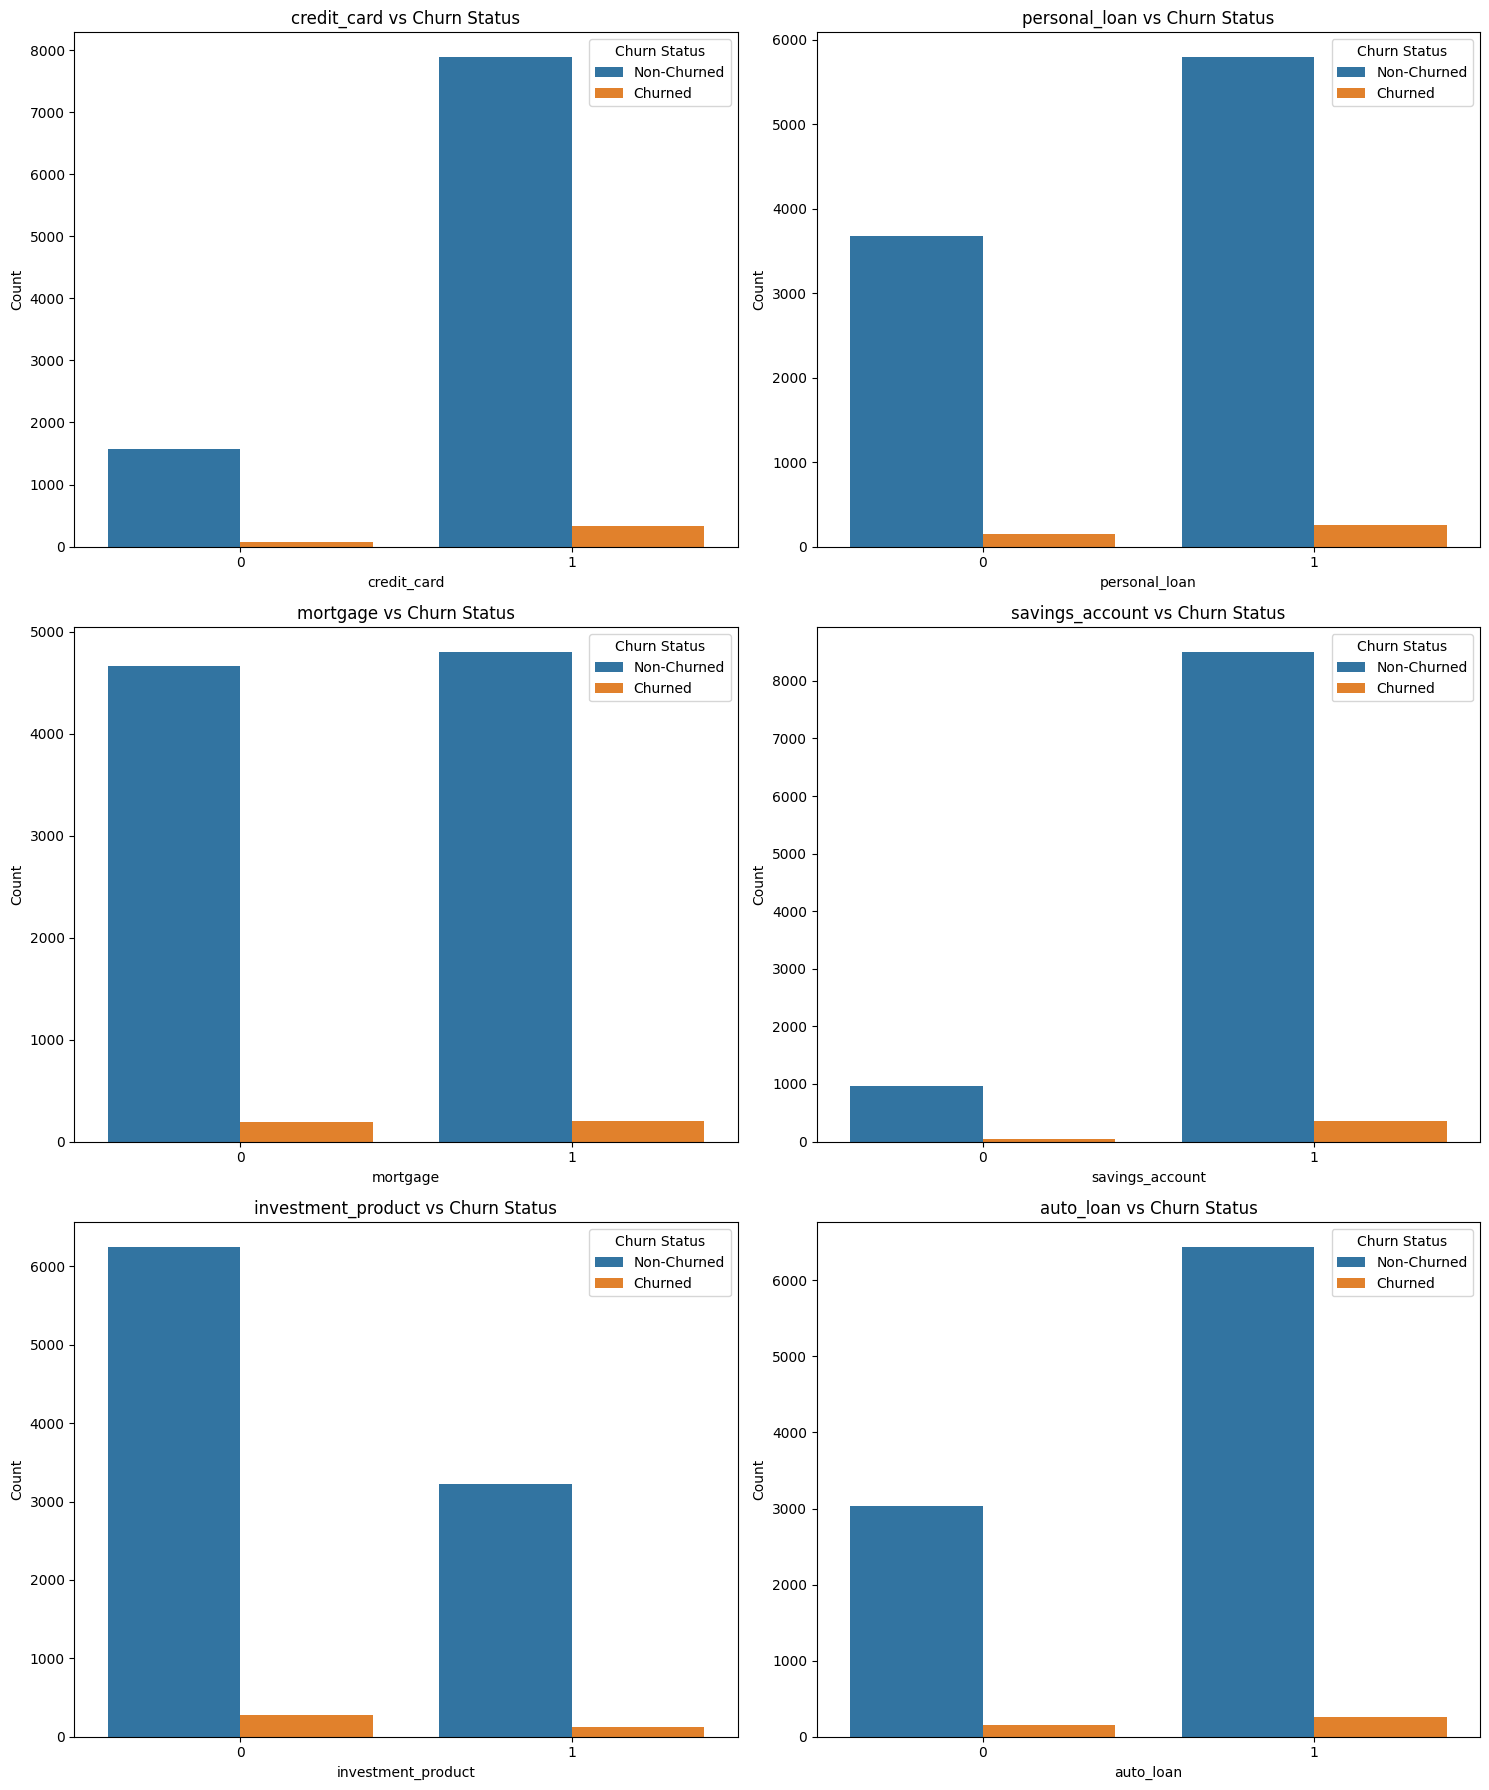

In [39]:
binary_columns = df.columns[10:16]
fig, axes = plt.subplots(3, 2, figsize=(15, 18))

for i, column in enumerate(binary_columns):
    sns.countplot(x=column, hue='churn_status', data=df, ax=axes[i // 2, i % 2])
    axes[i // 2, i % 2].set_title(f'{column} vs Churn Status')
    axes[i // 2, i % 2].set_xlabel(column)
    axes[i // 2, i % 2].set_ylabel('Count')
    axes[i // 2, i % 2].legend(title='Churn Status', labels=['Non-Churned', 'Churned'])

# Remove any empty subplots
for j in range(len(binary_columns), 6):
    fig.delaxes(axes[j // 2, j % 2])

plt.tight_layout()
plt.show()

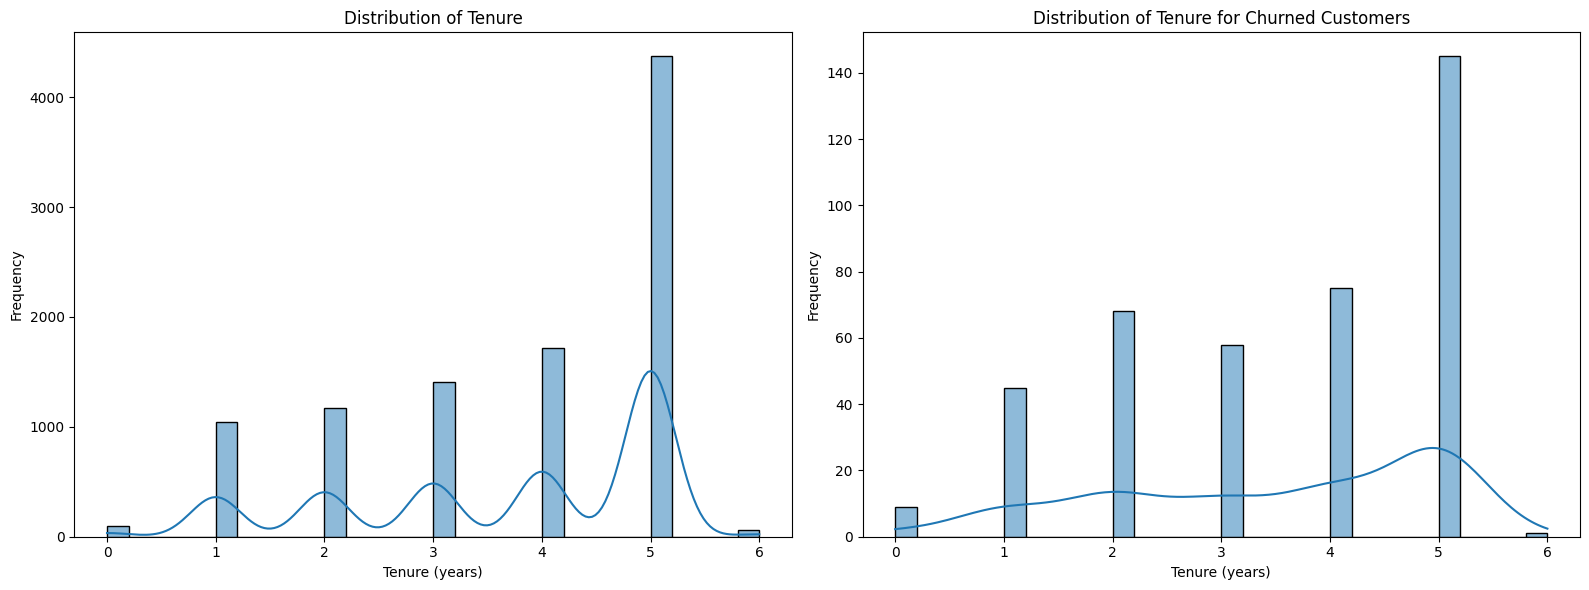

In [40]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot tenure
sns.histplot(df['tenure'], bins=30, kde=True, ax=axes[0])
axes[0].set_title('Distribution of Tenure')
axes[0].set_xlabel('Tenure (years)')
axes[0].set_ylabel('Frequency')

# Plot tenure for churned customers
sns.histplot(df[df['churn_status'] == 1]['tenure'], bins=30, kde=True, ax=axes[1])
axes[1].set_title('Distribution of Tenure for Churned Customers')
axes[1].set_xlabel('Tenure (years)')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

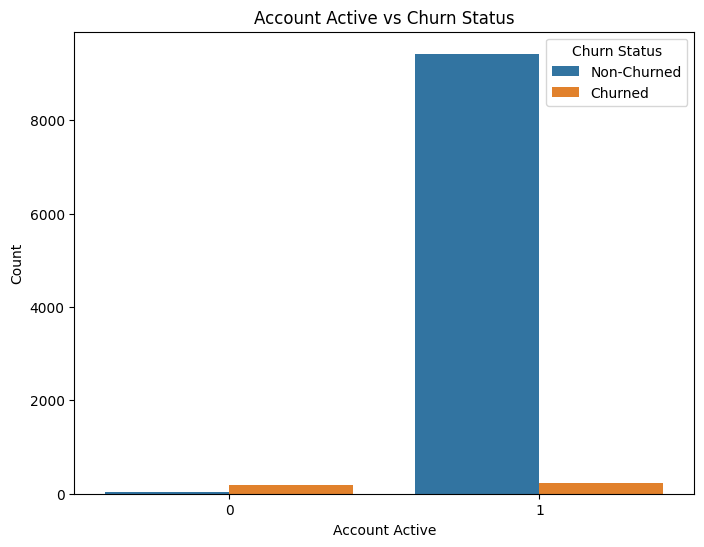

In [41]:
# Plot account_active against churn_status
plt.figure(figsize=(8, 6))
sns.countplot(x='account_active', hue='churn_status', data=df)
plt.title('Account Active vs Churn Status')
plt.xlabel('Account Active')
plt.ylabel('Count')
plt.legend(title='Churn Status', labels=['Non-Churned', 'Churned'])
plt.show()

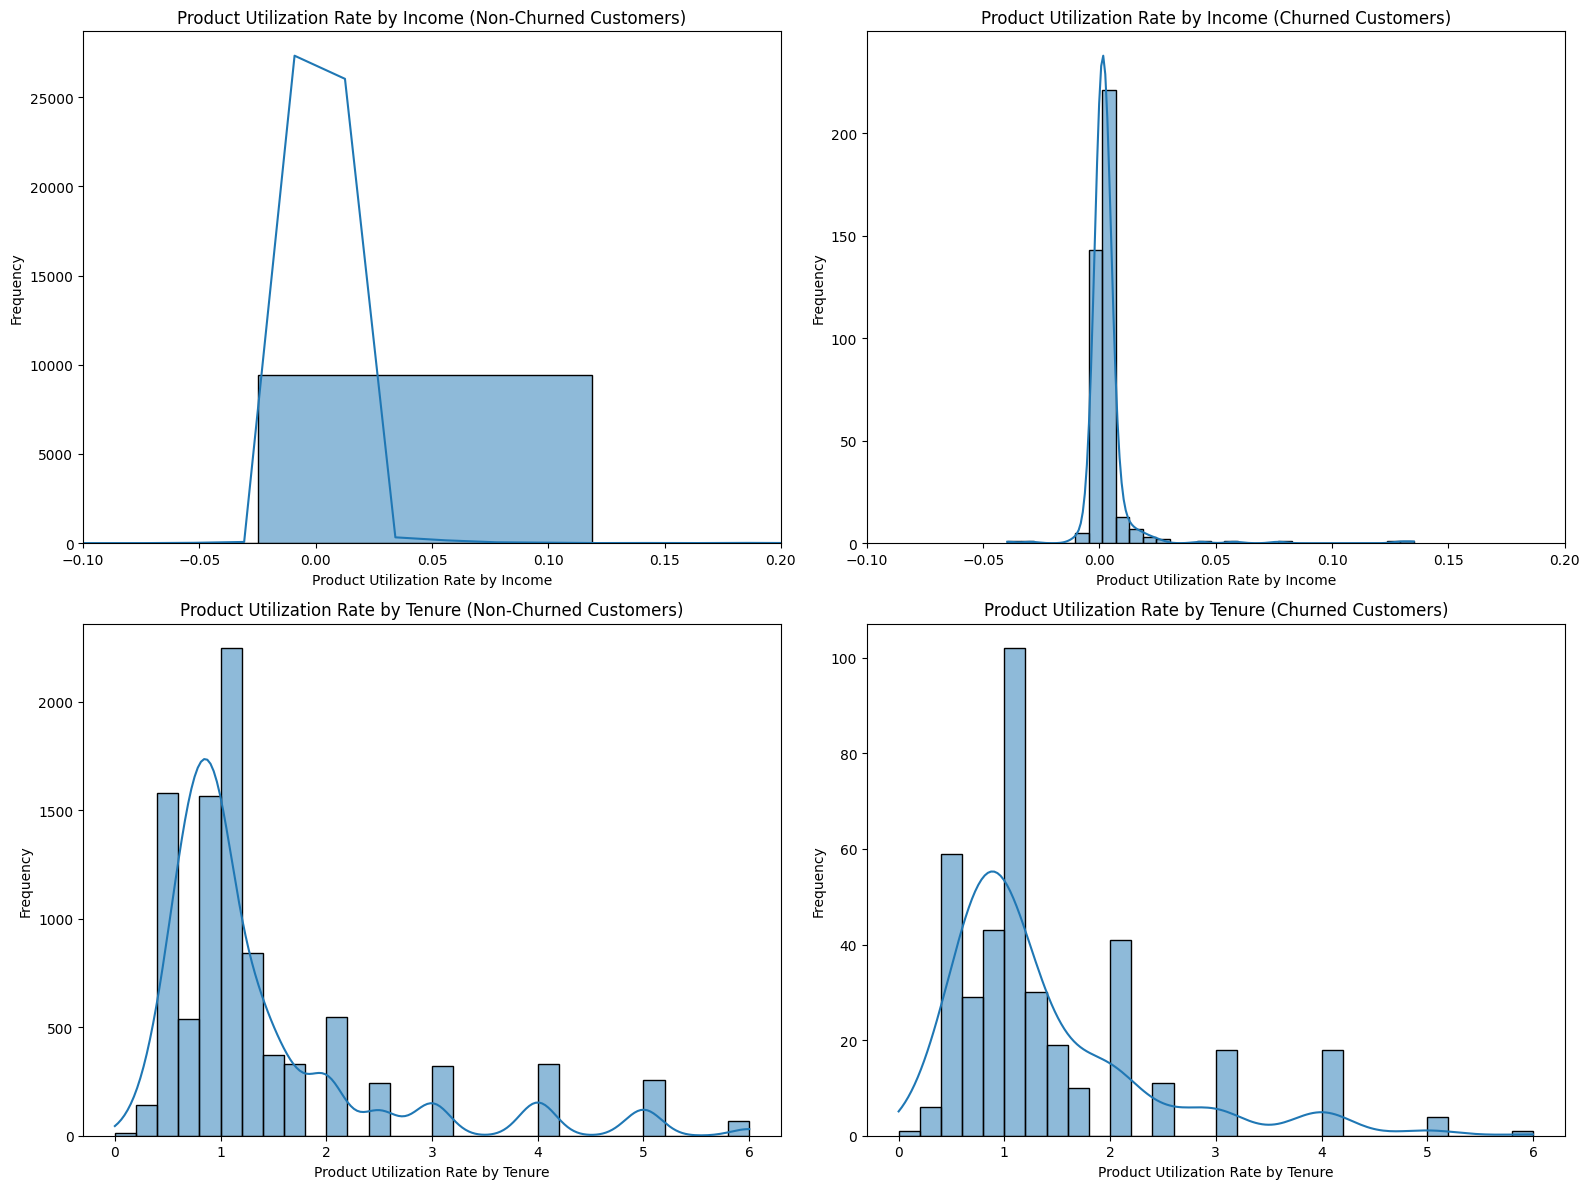

In [48]:
# Plot product_utilization_rate_by_income and product_utilization_rate_by_tenure side by side for churned and non-churned customers
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot product_utilization_rate_by_income for non-churned customers
sns.histplot(df[df['churn_status'] == 0]['product_utilization_rate_by_income'], bins=30, kde=True, ax=axes[0, 0])
axes[0, 0].set_title('Product Utilization Rate by Income (Non-Churned Customers)')
axes[0, 0].set_xlabel('Product Utilization Rate by Income')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_xlim(-0.1, 0.2)

# Plot product_utilization_rate_by_income for churned customers
sns.histplot(df[df['churn_status'] == 1]['product_utilization_rate_by_income'], bins=30, kde=True, ax=axes[0, 1])
axes[0, 1].set_title('Product Utilization Rate by Income (Churned Customers)')
axes[0, 1].set_xlabel('Product Utilization Rate by Income')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_xlim(-0.1, 0.2)

# Plot product_utilization_rate_by_tenure for non-churned customers
sns.histplot(df[df['churn_status'] == 0]['product_utilization_rate_by_tenure'], bins=30, kde=True, ax=axes[1, 0])
axes[1, 0].set_title('Product Utilization Rate by Tenure (Non-Churned Customers)')
axes[1, 0].set_xlabel('Product Utilization Rate by Tenure')
axes[1, 0].set_ylabel('Frequency')

# Plot product_utilization_rate_by_tenure for churned customers
sns.histplot(df[df['churn_status'] == 1]['product_utilization_rate_by_tenure'], bins=30, kde=True, ax=axes[1, 1])
axes[1, 1].set_title('Product Utilization Rate by Tenure (Churned Customers)')
axes[1, 1].set_xlabel('Product Utilization Rate by Tenure')
axes[1, 1].set_ylabel('Frequency')


plt.tight_layout()
plt.show()